In [24]:
%matplotlib inline    
import matplotlib as mplt
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')

from scipy.stats import lognorm
from scipy.stats import norm
# from scipy.stats import chisqprob

from numpy import prod
import seaborn as sns

# statiscal models
import statsmodels as sm
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR, DynamicVAR

from statsmodels.stats import diagnostic

# local packages
from utils_libs import *
from utils_data_prep import *

In [30]:
def para_parser(para_path):
    
    with open(para_path, "r") as ins:
        array = []
        para_dict = {}
    
        for line in ins:
            newline = line.strip('\n')
            tmpline = newline.split(',')
            
            if tmpline[1] =='int':
                para_dict.update( {tmpline[0]:int(tmpline[2])} )
            elif tmpline[1] =='bool':
                para_dict.update( {tmpline[0]: False if tmpline[2] == 'False' else True} )
        
        return para_dict


para_dict = para_parser("para_file.txt")
print para_dict


{'para_step_ahead': 0, 'para_order_hour': 16, 'para_order_minu': 30, 'roll_len': 2, 'bool_feature_selection': False, 'interval_len': 720}


In [9]:
a = [1,2,3,4,5]
print a[:-1]

[1, 2, 3, 4]


In [5]:
# --- Load pre-processed order book data ---

all_dta_minu = np.load("../dataset/bitcoin/dta_minu.dat")
all_loc_hour = np.load("../dataset/bitcoin/loc_hour.dat")
all_loc_month = np.load("../dataset/bitcoin/loc_month.dat")
print len(all_dta_minu), len(all_loc_hour), len(all_loc_month)

features_minu = np.load("../dataset/bitcoin/training_data/feature_minu.dat")
rvol_hour = np.load("../dataset/bitcoin/training_data/return_vol_hour.dat")
print np.shape(features_minu), np.shape(rvol_hour)

# --- Load order book data files ---

# all_dta_minu, all_loc_hour, all_loc_month = load_raw_order_book_files('../dataset/bitcoin/order_book/*.csv', True)

701892 13729 606
(701892, 10) (13729,)


In [5]:
# --- calculate price, return and volatility ---

price_minu, req_minu = cal_price_req_minu(all_dta_minu)

print np.shape(price_minu), np.shape(req_minu)

#pvol_hour = cal_price_volatility_hour( all_loc_hour, price_minu )
return_minu, rvol_hour = cal_return_volatility_hour( all_loc_hour, price_minu, 'per' )

print len(price_minu),len(return_minu), len(rvol_hour)

# --- extract features w.r.t. minutes ---

features_minu = [] 

for i in range( len(all_dta_minu) ):
    
    # shape: index by [price, amount]
    tmp_a = all_dta_minu[i][0]
    tmp_b = all_dta_minu[i][1]

    '''
    tmpft = mle_norm_2d(tmp_a)
    tmp = tmpft[0] + tmpft[1]
    
    tmpft = mle_norm_2d(tmp_b)
    tmp += tmpft[0]
    tmp += tmpft[1]
    
    # skewness feature
    tmp += skewness(tmp_a)
    tmp += skewness(tmp_b)
    
    # amount of requests
    tmp += [len(all_dta_minu[i][0]), len(all_dta_minu[i][1])] 
    
    '''
    features_minu.append( orderbook_stat_features(all_dta_minu, i) )
    
#  shape: [miniutes, features]
features_minu = np.reshape( features_minu, (len(features_minu), -1) )

print np.shape( np.asarray(features_minu) )

np.asarray(features_minu).dump("../dataset/bitcoin/training_data/feature_minu.dat")
np.asarray(rvol_hour ).dump("../dataset/bitcoin/training_data/return_vol_hour.dat")


In [8]:
# --- parameter set-up for preparing trainning and testing data ---
para_order_minu = 30
para_order_hour = 16
para_train_split_ratio = 0.8
bool_feature_selection = False


In [62]:
# --- obtain training and testing data, plain regression ---

file_postfix = "v_minu_reg" 

# features_minu, req_minu, pvol_hour, all_loc_hour
x, y, var_explain = prepare_feature_target( features_minu, rvol_hour, all_loc_hour, \
                                                        para_order_minu, para_order_hour, bool_feature_selection )
# shape of x[i][1]: [T, Features]
print len(x), np.shape(x[0][0]), np.shape(x[0][1])
    
xtrain, ytrain, xtest, ytest = training_testing_plain_regression(x, y, para_train_split_ratio)    

#test
xtest = xtest[300:]
ytest = ytest[300:]


print np.shape(xtrain), np.shape(ytrain), np.shape(xtest), np.shape(ytest)
np.asarray(xtrain).dump("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
np.asarray(xtest ).dump("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
np.asarray(ytrain).dump("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
np.asarray(ytest ).dump("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")


10625 (16,) (10, 10)
(8500, 116) (8500,) (1825, 116) (1825,)


In [23]:
# --- obtain training and testing data, arima, structural time series ---

file_postfix = "stat" 

xtrain, extrain, xtest, extest = training_testing_statistic(features_minu, rvol_hour, all_loc_hour, \
                                para_order_minu, para_order_hour, para_train_split_ratio, bool_feature_selection)

print np.shape(xtrain), np.shape(extrain), np.shape(xtest), np.shape(extest)

np.asarray(xtrain).dump("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
np.asarray(xtest ).dump("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
np.asarray(extrain).dump("../dataset/bitcoin/training_data/extrain_"+file_postfix+".dat")
np.asarray(extest ).dump("../dataset/bitcoin/training_data/extest_" +file_postfix+".dat")


(8515,) (8515, 200) (2125,) (2125, 200)


In [61]:
# --- obtain training and testing data, garch ---

file_postfix = "garch" 

vol_train, rt_train, vol_test, rt_test = training_testing_garch(rvol_hour, all_loc_hour, para_order_hour, \
                                                                para_train_split_ratio, price_minu)

print np.shape(vol_train), np.shape(rt_train), np.shape(vol_test), np.shape(rt_test)
print len(rt_train)+len(rt_test), len(vol_train)+len(vol_test)

np.asarray(vol_train).dump("../dataset/bitcoin/training_data/voltrain_"+file_postfix+".dat")
np.asarray(rt_train).dump("../dataset/bitcoin/training_data/rttrain_"  +file_postfix+".dat")
np.asarray(vol_test).dump("../dataset/bitcoin/training_data/voltest_"  +file_postfix+".dat")
np.asarray(rt_test).dump("../dataset/bitcoin/training_data/rttest_"    +file_postfix+".dat")

(8515,) (8515,) (2125,) (2125,)
10640 10640


In [29]:
# --- obtain training and testing data, mixture, shape of external features [T*D] --- 

file_postfix = "v_minu_mix"

# features_minu, req_minu, pvol_hour, all_loc_hour
x, y, var_explain = prepare_feature_target( features_minu, rvol_hour, all_loc_hour, \
                                           para_order_minu, para_order_hour, bool_feature_selection )

print len(x), np.shape(x[0][0]), np.shape(x[0][1])

xtrain, ytrain, xtest, ytest = training_testing_mixture_mlp(x, y, para_train_split_ratio)

#test
xtest = xtest[300:]
ytest = ytest[300:]

print len(xtrain[0]), len(xtrain[0][0]), len(xtrain[0][1]), np.shape(ytrain), np.shape(ytest)
np.asarray(xtrain).dump("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
np.asarray(xtest ).dump("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
np.asarray(ytrain).dump("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
np.asarray(ytest ).dump("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

#  done for training-test preparaion 

10625 (16,) (10, 10)
2 16 100 (8500,) (1825,)


In [92]:
# --- obtain training and testing data, mixture, shape of external features [T, D] --- 

file_postfix = "v_minu_mix"

# features_minu, req_minu, pvol_hour, all_loc_hour
x, y, var_explain = prepare_feature_target( features_minu, rvol_hour, all_loc_hour, \
                                           para_order_minu, para_order_hour, bool_feature_selection )
print len(x)

xtrain, ytrain, xtest, ytest = training_testing_mixture_rnn(x, y, para_train_split_ratio)

#test
xtest = xtest[300:]
ytest = ytest[300:]

print len(xtrain[0]), np.shape(xtrain[0][0]), np.shape(xtrain[0][1]), np.shape(ytrain), np.shape(ytest)
np.asarray(xtrain).dump("../dataset/bitcoin/training_data/xtrain_"+file_postfix+".dat")
np.asarray(xtest ).dump("../dataset/bitcoin/training_data/xtest_" +file_postfix+".dat")
np.asarray(ytrain).dump("../dataset/bitcoin/training_data/ytrain_"+file_postfix+".dat")
np.asarray(ytest ).dump("../dataset/bitcoin/training_data/ytest_" +file_postfix+".dat")

# full shape back-up
np.asarray(xtrain).dump("../dataset/bitcoin/training_data/xtrain_orig.dat")


10625
2 (16,) (30, 10) (8500,) (1825,)


percent:  0.999717647059


(0.95, 1)

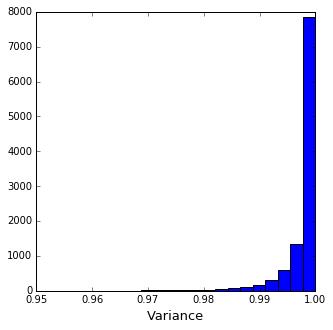

In [10]:
# --- explained variance in feature selection ---

print 'percent: ', sum([1 for i in var_explain if i>=0.95])*1.0/len(var_explain)

fig, ax = plt.subplots()
fig.set_size_inches( 5,5 )
ax.hist(var_explain, histtype='bar',  \
        label=['Variance explained'], bins = 30)
# ax.set_title('Price proposed by ask and bit requests on one minute', fontsize=13)
ax.set_xlabel('Variance explained', fontsize=13)
ax.set_xlim(0.95,1)

In [9]:
# load raw feature and target data
features_minu = np.load("../dataset/bitcoin/training_data/feature_minu.dat")
rvol_hour = np.load("../dataset/bitcoin/training_data/return_vol_hour.dat")
all_loc_hour = np.load("../dataset/bitcoin/loc_hour.dat")
    
all_dta_minu = np.load("../dataset/bitcoin/dta_minu.dat")
price_minu, req_minu = cal_price_req_minu(all_dta_minu)
    
print np.shape(rvol_hour)
    
# prepare the set of pairs of features and targets
x, y, var_explain = prepare_feature_target( features_minu, rvol_hour, all_loc_hour, \
                                                        para_order_minu, para_order_hour, bool_feature_selection )

(13729,)


In [11]:
# INTERVAL DATA
    
print np.shape(rvol_hour), np.shape(y), len(all_loc_hour)
    
# set up the training and evaluation interval 
interval_len = 30*24
interval_num = int(len(y)/interval_len)
print np.shape(x), np.shape(y), interval_len, interval_num
roll_len = 2
    

train_mode = 'roll'


# the main loop
for i in range(roll_len + 1, interval_num + 1):
    # extract the data within the current time interval
    if train_mode == 'roll':
        
        tmp_x = x[(i-roll_len-1)*interval_len : i*interval_len]
        tmp_y = y[(i-roll_len-1)*interval_len : i*interval_len]
        
        tmp_l = (i-roll_len-1)*interval_len
        tmp_r = i*interval_len-1
            
    elif train_mode == 'incre':
        
        tmp_x = x[ : i*interval_len]
        tmp_y = y[ : i*interval_len]
        
        tmp_l = 0
        tmp_r = i*interval_len-1
        
    para_train_split_ratio = 1.0*( (tmp_r-tmp_l+1) - interval_len )/(tmp_r-tmp_l)
    
    tmpl = tmp_l + para_order_hour
    tmpr = tmp_r + para_order_hour
    tmp_mid = tmpl +  interval_len*roll_len - 1
    #int( tmp_l + (tmp_r-tmp_l)*para_train_split_ratio )
    
    print tmpl, tmp_mid, tmpr
    
    minu_l = all_loc_hour[tmpl]
    minu_mid = all_loc_hour[tmp_mid]
    minu_r = all_loc_hour[tmpr+1]
    
    data_minu_train = price_minu[minu_l : minu_mid+1]
    data_minu_test  = price_minu[minu_mid+1 : minu_r]
    
    print 'shape', np.shape(data_minu_train), np.shape(data_minu_test)
    
#         if para_bool_bilinear == True:
#             xtrain, ytrain, xtest, ytest = training_testing_mixture_rnn(tmp_x, tmp_y, para_train_split_ratio)
#         else:
#             xtrain, ytrain, xtest, ytest = training_testing_mixture_mlp(tmp_x, tmp_y, para_train_split_ratio)
        
    # dump training and testing data in one interval to disk 
    np.asarray(data_minu_train).dump("../dataset/bitcoin/training_data/rolling_minu/" + str(i-1) + "_train.dat")
    np.asarray(data_minu_test ).dump("../dataset/bitcoin/training_data/rolling_minu/" + str(i-1) + "_test.dat")
        
        

(13729,) (13713,) 13729
(13713, 2) (13713,) 720 19
16 1455 2175
shape (54353,) (27756,)
736 2175 2895
shape (54921,) (28451,)
1456 2895 3615
shape (56091,) (27549,)
2176 3615 4335
shape (55880,) (39257,)
2896 4335 5055
shape (66668,) (41410,)
3616 5055 5775
shape (80510,) (41192,)
4336 5775 6495
shape (82426,) (41200,)
5056 6495 7215
shape (82216,) (42049,)
5776 7215 7935
shape (83073,) (42362,)
6496 7935 8655
shape (84234,) (42150,)
7216 8655 9375
shape (84335,) (35555,)
7936 9375 10095
shape (77528,) (43190,)
8656 10095 10815
shape (78568,) (43219,)
9376 10815 11535
shape (86232,) (43215,)
10096 11535 12255
shape (86257,) (41004,)
10816 12255 12975
shape (84048,) (36026,)
11536 12975 13695
shape (76870,) (32166,)


In [8]:
import numpy as np
import tensorflow as tf

point_cloud = tf.placeholder(tf.float32, shape=[None,3])
eps = tf.placeholder(tf.float32, shape=[None])

mask = tf.greater(point_cloud[:,2], eps)
reduced_cloud = tf.boolean_mask(point_cloud, mask)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    sess.run(init)
    _cloud = np.random.rand(5,3)
    print _cloud
    
    feed = {point_cloud:_cloud, eps:[0.5]}
    mask, filtered = sess.run( [mask, reduced_cloud], feed_dict=feed)
    
    print mask
    print filtered

[[0.35906979 0.40477864 0.27161129]
 [0.17371957 0.97553405 0.71700633]
 [0.36807989 0.35002124 0.31203351]
 [0.70679767 0.25048288 0.24110495]
 [0.29342085 0.19734709 0.10167807]]
[False  True False False False]
[[0.17371957 0.975534   0.7170063 ]]
